In [1]:
# Curating organoids cell types and projection with in vivo data
import anndata, numpy as np, pandas as pd, imp, lpy, scanpy as sc, random
sc.logging.print_header()
%load_ext rpy2.ipython
%matplotlib inline

scanpy==1.6.0 anndata==0.7.5 umap==0.3.10 numpy==1.18.1 scipy==1.5.4 pandas==1.0.1 scikit-learn==0.22.2 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.8.3
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
# load organoid and subset to the E001 clone clusters are PGR+ 
adata = anndata.read_h5ad("N2-integrated_organoids.h5ad")
adatasub = adata[ [ x in ["8", "3", "0", "6", "5"] for x in adata.obs["leiden_scvi_genotype_E001_LMT_hormones"] ] ,: ]

In [3]:
# run Palentir on the subset, picks a start cell that is in the "highest entropy" area, detected from a previous run of palentir
which = lambda lst:list(np.where(lst)[0])
startcell = random.sample(which(adatasub.obs["leiden_scvi_genotype_E001_LMT_hormones"] == "8"), 1)
print(startcell)
imp.reload(lpy)
res = lpy.runPalantir(adatasub, adatasub.obs_names[startcell], doinspect=True)

[767]
Compute Trajectory using Palantir
def runPalantir(adata, startcell, doinspect = False):
    if doinspect is True: print("\033Compute Trajectory using Palantir\033\033"); print(inspect.getsource(runPalantir));print("\033Execution:\033")
    import palantir
    #import harmony
    if 'highly_variable' not in adata.var.keys():
        sc.pp.highly_variable_genes(adata,inplace=True)
    pca_projections, _ = palantir.utils.run_pca(adata)
    dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)
    ms_data = palantir.utils.determine_multiscale_space(dm_res)
    pr_res = palantir.core.run_palantir(ms_data, startcell, num_waypoints=500)
    

    return(pr_res)

Execution:
Determing nearest neighbor graph...
Sampling and flocking waypoints...
Time for determining waypoints: 0.009520912170410156 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.3454362154006958 minutes
Iteratively refining the pse

In [4]:
adata.obs["pseudotime"] = res.pseudotime
adata.obs["entropy"] = res.entropy

adata.obs["prob1"] = res.branch_probs[res.branch_probs.keys()[0]]
adata.obs["prob2"] = res.branch_probs[res.branch_probs.keys()[1]]
sc.pl.umap(adata, color=["pseudotime", "entropy", "prob1", "prob2"], save= "color.pdf", color_map = "viridis",size=10)

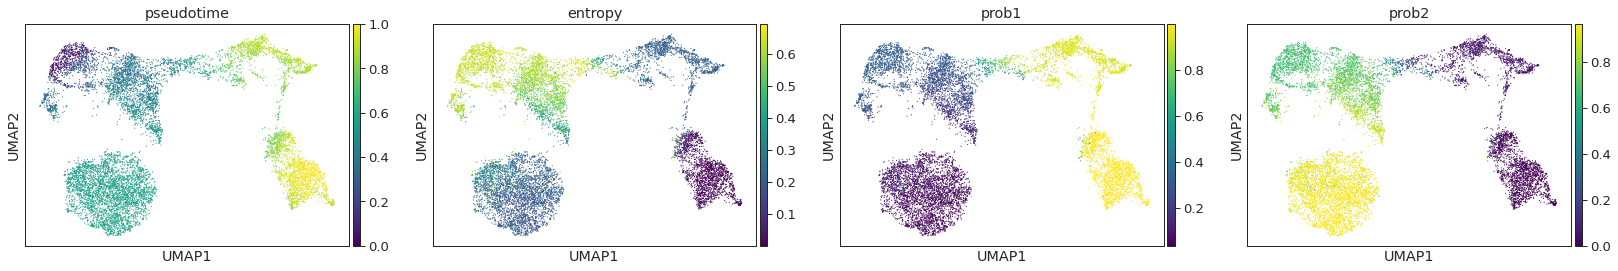

In [5]:
sc.pl.umap(adata, color=["pseudotime", "entropy", "prob1", "prob2"], color_map = "viridis",size=5)

In [6]:
adata.write_h5ad("N4-integrated_organoids.h5ad")